# Содержание
1. Описание набора данных
2. Проведение разведочного анализа данных
3. Предобработка данных
4. Выбор метрик для последующей оценки качества моделей
5. Выбор наиболее подходящих моделей для решения задачи классификации или регрессии
6. Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров
7. Подбор гиперпараметров для выбранных моделей
8. Сравнение качества полученных моделей с качеством baseline-моделей
9. Формирование выводов о качестве построенных моделей на основе выбранных метрик

## Описание набора данных

В качестве набора данных мы будем использовать набор данных за 10 лет ежедневных наблюдений за погодой из многих мест по всей Австралии. С его помощью можно прогнозировать дождь на следующий день, обучив модели классификации на целевой переменной RainTomorrow.

* Date - Дата наблюдений
* Location - Название локации, в которой расположена метеорологическая станция
* MinTemp - Минимальная температура в градусах цельсия
* MaxTemp - Максимальная температура в градусах цельсия
* Rainfall - Количество осадков, зафиксированных за день в мм
* Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
* Sunshine - Число солнечных часов за день
* WindGustDir - направление самого сильного порыва ветра за последние 24 часа
* WindGustSpeed -  скорость (км / ч) самого сильного порыва ветра за последние 24 часа
* WindDir9am - направление ветра в 9 утра

Для решения задачи классификации в качестве целевого признака будем использовать "RainTomorrow". Поскольку признак содержит только значения "No" и "Yes", то это задача бинарной классификации

In [1]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt

import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedKFold, StratifiedKFold

In [4]:
from IPython.display import Image
from io import StringIO
import graphviz
import pydotplus
from sklearn.tree import export_graphviz

In [5]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.2, a-0.1, str(round(b,3)), color='white')
        plt.show()    

In [6]:
data = pd.read_csv('weatherAUS.csv', parse_dates=['Date'])

## Проведение разведочного анализа данных

In [7]:
data.shape

(142193, 24)

In [3]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           142193 non-null  datetime64[ns]
 1   Location       142193 non-null  object        
 2   MinTemp        141556 non-null  float64       
 3   MaxTemp        141871 non-null  float64       
 4   Rainfall       140787 non-null  float64       
 5   Evaporation    81350 non-null   float64       
 6   Sunshine       74377 non-null   float64       
 7   WindGustDir    132863 non-null  object        
 8   WindGustSpeed  132923 non-null  float64       
 9   WindDir9am     132180 non-null  object        
 10  WindDir3pm     138415 non-null  object        
 11  WindSpeed9am   140845 non-null  float64       
 12  WindSpeed3pm   139563 non-null  float64       
 13  Humidity9am    140419 non-null  float64       
 14  Humidity3pm    138583 non-null  float64       
 15  

В данных есть пропуски. Желтым показаны пропущенные значения, синим - заполненные.

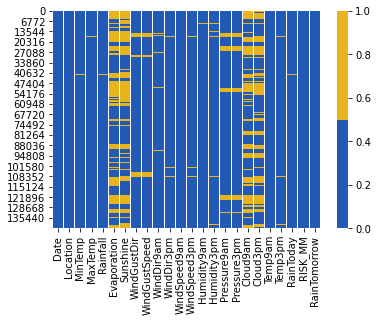

In [4]:
cols = data.columns
colours = ['#235AB5', '#E8B41E'] 
sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colours))

## Предобработка данных

Заполнение пропусков в данных.

Рассмотрим числовые колонки с пропущенными значениями:

In [7]:
total_count = data.shape[0]
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка MinTemp. Тип данных float64. Количество пустых значений 637, 0.45%.
Колонка MaxTemp. Тип данных float64. Количество пустых значений 322, 0.23%.
Колонка Rainfall. Тип данных float64. Количество пустых значений 1406, 0.99%.
Колонка Evaporation. Тип данных float64. Количество пустых значений 60843, 42.79%.
Колонка Sunshine. Тип данных float64. Количество пустых значений 67816, 47.69%.
Колонка WindGustSpeed. Тип данных float64. Количество пустых значений 9270, 6.52%.
Колонка WindSpeed9am. Тип данных float64. Количество пустых значений 1348, 0.95%.
Колонка WindSpeed3pm. Тип данных float64. Количество пустых значений 2630, 1.85%.
Колонка Humidity9am. Тип данных float64. Количество пустых значений 1774, 1.25%.
Колонка Humidity3pm. Тип данных float64. Количество пустых значений 3610, 2.54%.
Колонка Pressure9am. Тип данных float64. Количество пустых значений 14014, 9.86%.
Колонка Pressure3pm. Тип данных float64. Количество пустых значений 13981, 9.83%.
Колонка Cloud9am. Тип данных float

/Users/nonpenguin/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/nonpenguin/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


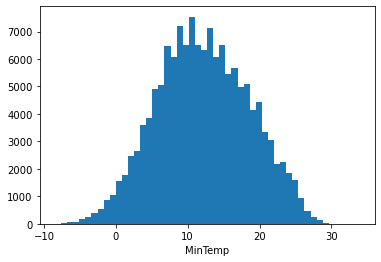

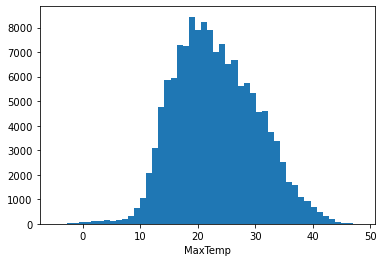

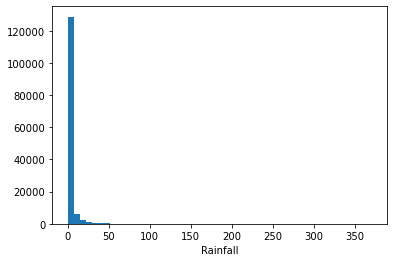

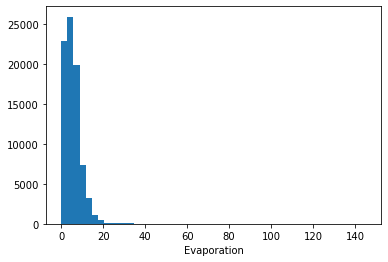

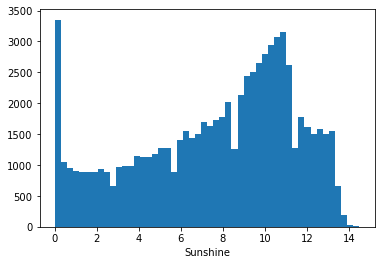

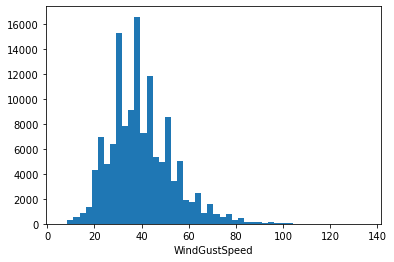

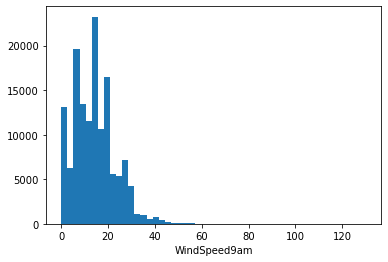

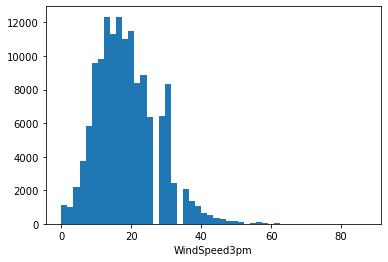

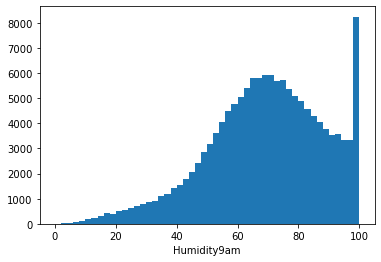

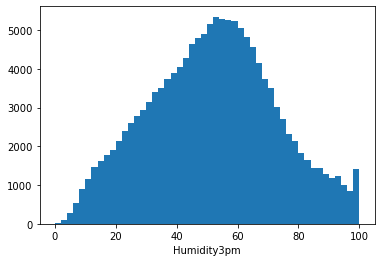

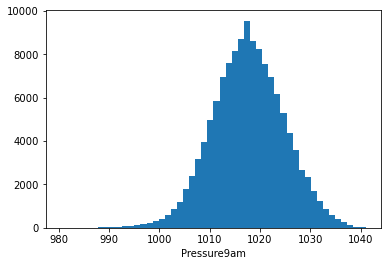

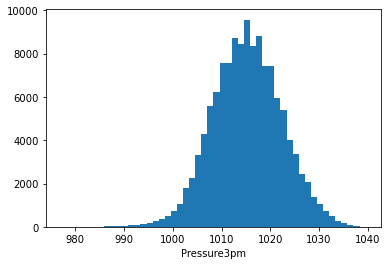

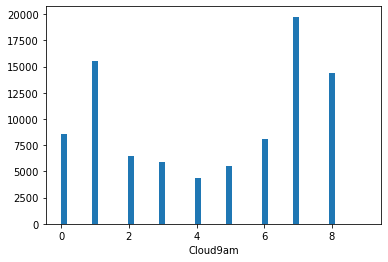

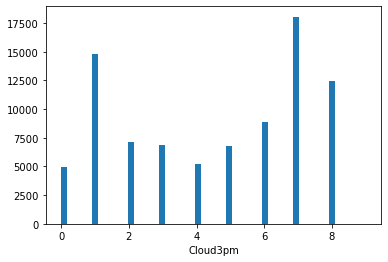

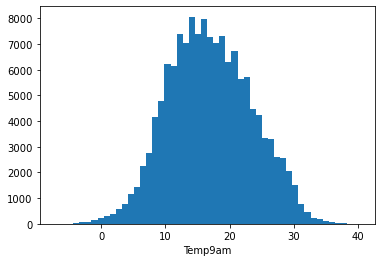

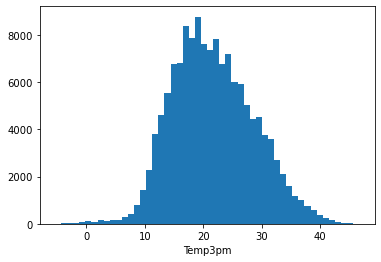

In [124]:
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

В столбцах Evaporation, Sunshine, Cloud9am, Cloud3pm большой процент пропущенных данных, и их корреляция с целевым признаком низкая, так что удалим эти признаки.

In [7]:
data = data.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis = 1)

In [7]:
miss_med = ['MinTemp', 'MaxTemp', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
data[miss_med] = data[miss_med].fillna(data[miss_med].median())

В одномодальных распределениях заполним пропуски значением моды

In [8]:
miss_mode_list = ['Rainfall', 'WindSpeed9am', 'WindSpeed3pm']
for miss_mode in miss_mode_list:
    data[miss_mode] = data[miss_mode].fillna(data[miss_mode].mode()[0])

Рассмотрим пропуски в категориальных данных

In [152]:
cat_cols = []
for col in data.columns:
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка WindGustDir. Тип данных object. Количество пустых значений 9330, 6.56%.
Колонка WindDir9am. Тип данных object. Количество пустых значений 10013, 7.04%.
Колонка WindDir3pm. Тип данных object. Количество пустых значений 3778, 2.66%.
Колонка RainToday. Тип данных object. Количество пустых значений 1406, 0.99%.


In [9]:
data[:] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(data)

In [8]:
data = data.dropna(axis=0, how='any')

In [12]:
data.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RISK_MM          0
RainTomorrow     0
dtype: int64

Кодирование категориальных признаков

In [27]:
total_count = data.shape[0]
num_cols = []
for col in data.columns: 
    dt = str(data[col].dtype)
    if (dt=='object'):
        num_cols.append(col)        
        print('Колонка {}. Количество категорий: {}'.format(col, data[col].unique().shape[0]))

Колонка Location. Количество категорий: 49
Колонка WindGustDir. Количество категорий: 16
Колонка WindDir9am. Количество категорий: 16
Колонка WindDir3pm. Количество категорий: 16
Колонка RainToday. Количество категорий: 2
Колонка RainTomorrow. Количество категорий: 2


In [9]:
data['RainToday'] = data['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0)
data['RainTomorrow'] = data['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)

Удалим признаки с информацией о направлении ветра и городах, так как они мало влияют на дожди

In [10]:
data = data.drop(['WindDir3pm','WindDir9am', 'WindGustDir'], axis = 1)

In [11]:
data = data.drop(['Location'], axis = 1)

Мы можем выделить из даты месяц, а потом разбить на времена года. Возможно, удастся заметить какой-нибудь сезон дождей.

In [12]:
data['Date'] = pd.DatetimeIndex(data['Date']).month

In [13]:
data["Winter"] = (data["Date"] == 12) | (data["Date"] == 1) | (data["Date"] == 2)
data["Spring"] = (data["Date"] >= 3) & (data["Date"] <= 5)
data["Summer"] = (data["Date"] >= 6) & (data["Date"] <= 8)
data["Autumn"] = (data["Date"] >= 9) & (data["Date"] <= 11)

In [14]:
from sklearn.preprocessing import LabelEncoder

lab_enc = LabelEncoder()
data['Winter'] = lab_enc.fit_transform(data['Winter'])
data['Spring'] = lab_enc.fit_transform(data['Spring'])
data['Summer'] = lab_enc.fit_transform(data['Summer'])
data['Autumn'] = lab_enc.fit_transform(data['Autumn'])

0    22649
1     5529
Name: RainTomorrow, dtype: int64
0    22641
1     6366
Name: RainTomorrow, dtype: int64
0    20044
1     7258
Name: RainTomorrow, dtype: int64
0    22572
1     5866
Name: RainTomorrow, dtype: int64


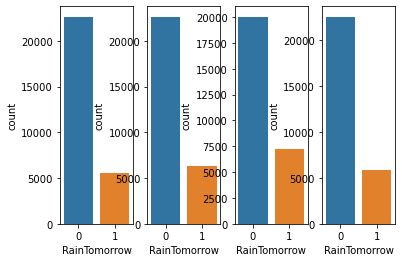

<Figure size 1440x1440 with 0 Axes>

In [36]:
fig, ax =plt.subplots(1,4)
print((data[data['Winter']==1])['RainTomorrow'].value_counts())
print((data[data['Spring']==1])['RainTomorrow'].value_counts())
print((data[data['Summer']==1])['RainTomorrow'].value_counts())
print((data[data['Autumn']==1])['RainTomorrow'].value_counts())

plt.figure(figsize=(20,20))
sns.countplot(data=data[data['Winter']==1], x='RainTomorrow', ax=ax[0])
sns.countplot(data=data[data['Spring']==1], x='RainTomorrow', ax=ax[1])
sns.countplot(data=data[data['Summer']==1], x='RainTomorrow', ax=ax[2])
sns.countplot(data=data[data['Autumn']==1], x='RainTomorrow', ax=ax[3])

Масштабирование данных

In [15]:
min_max_scaler = MinMaxScaler()
data[:] = min_max_scaler.fit_transform(data)

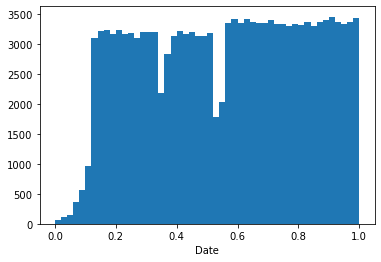

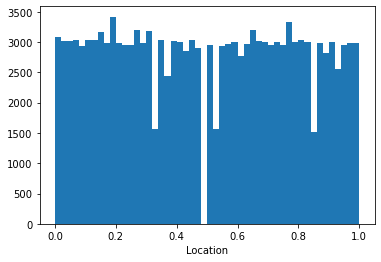

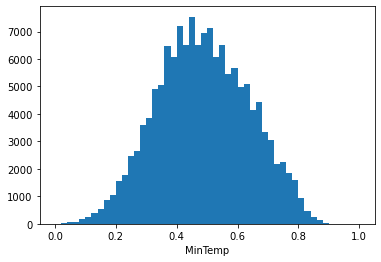

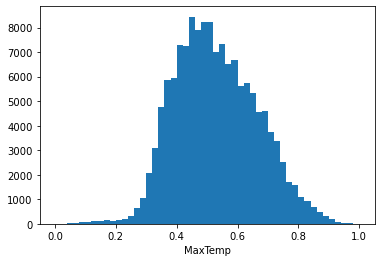

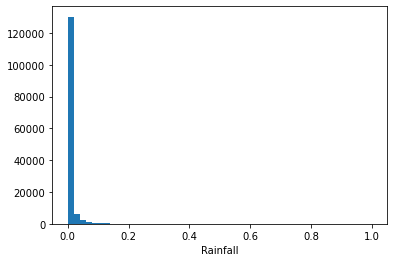

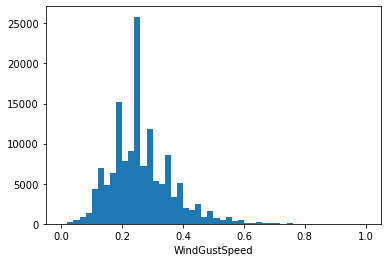

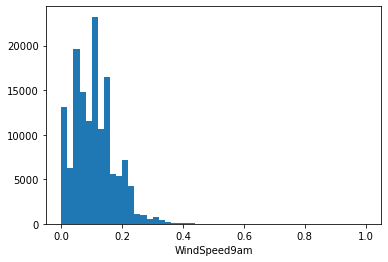

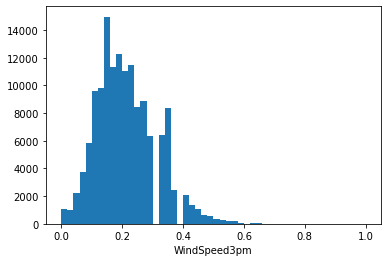

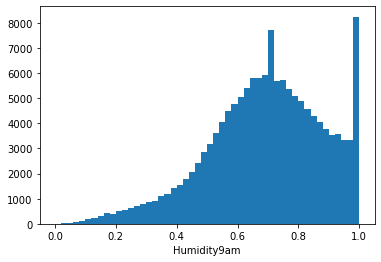

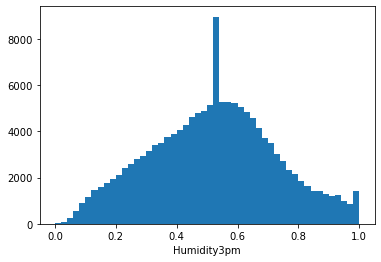

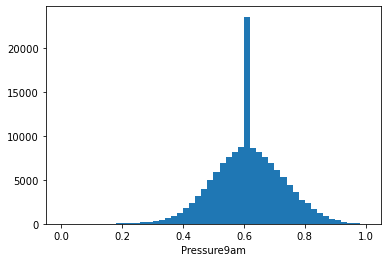

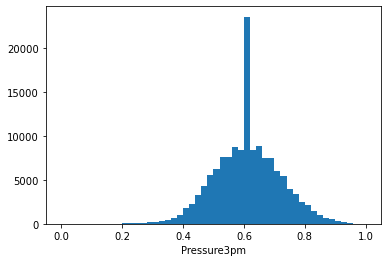

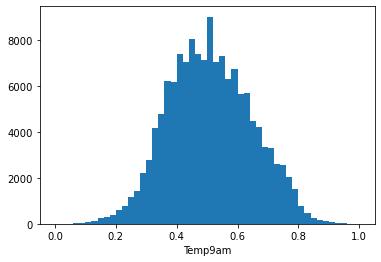

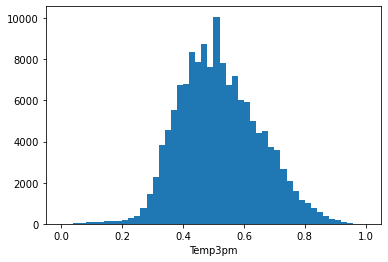

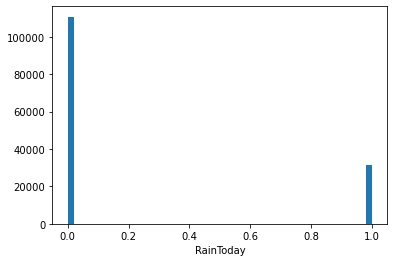

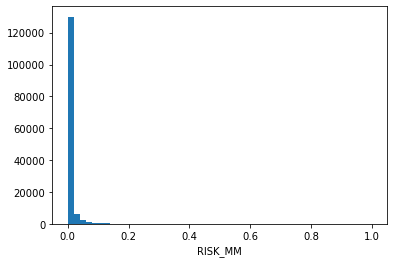

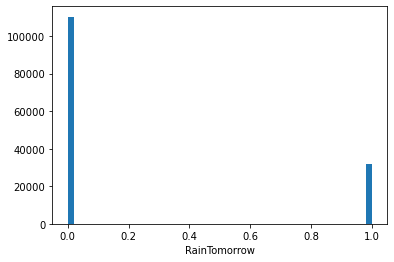

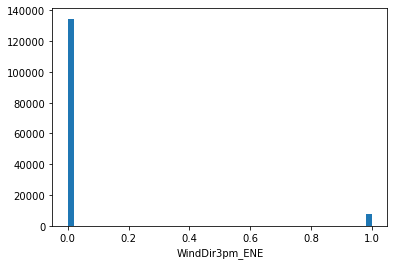

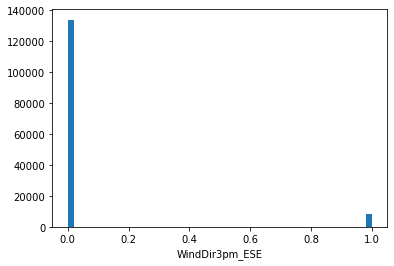

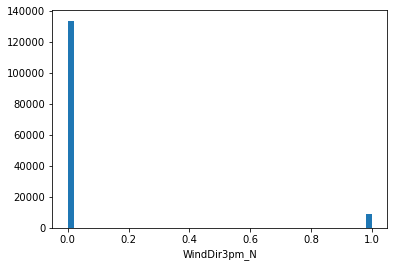

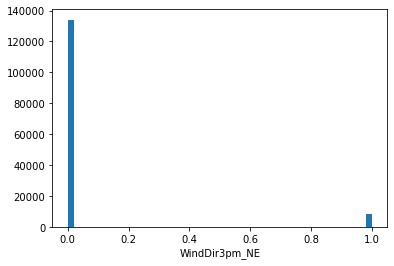

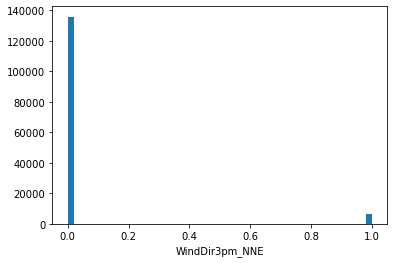

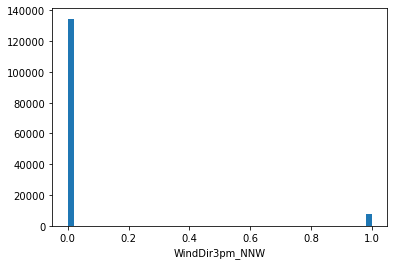

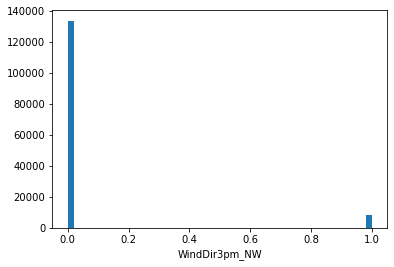

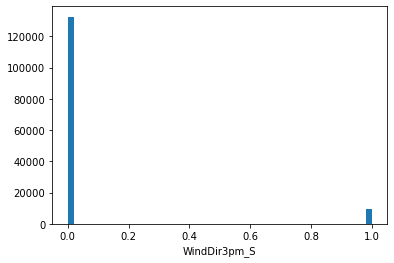

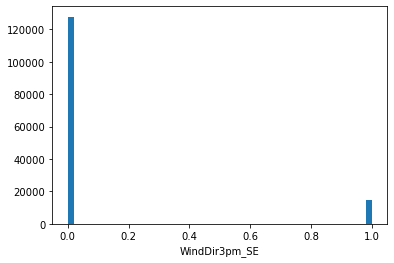

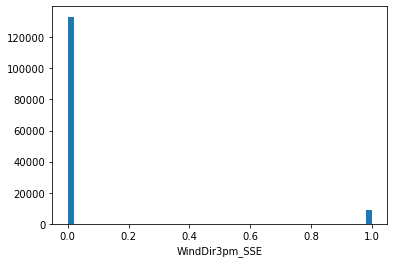

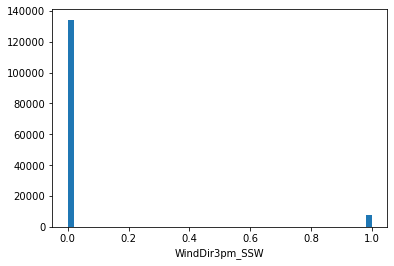

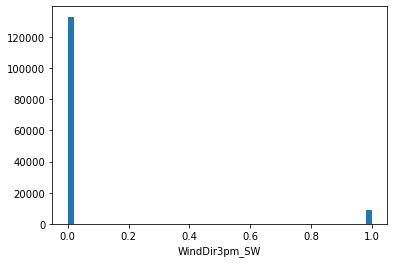

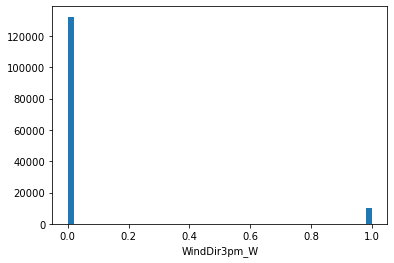

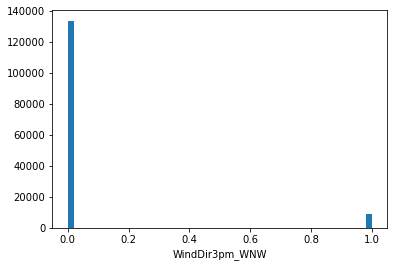

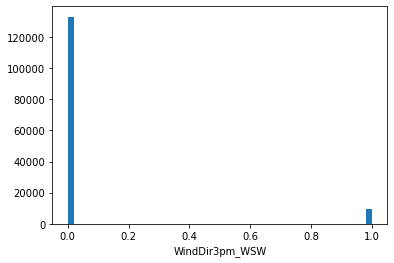

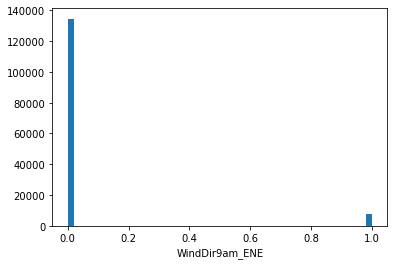

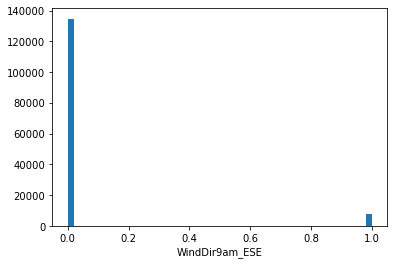

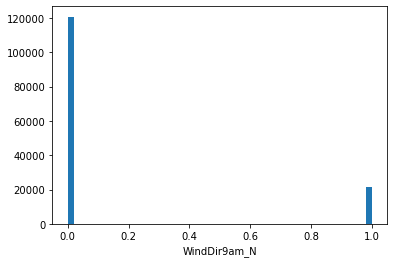

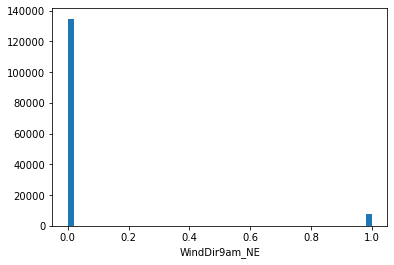

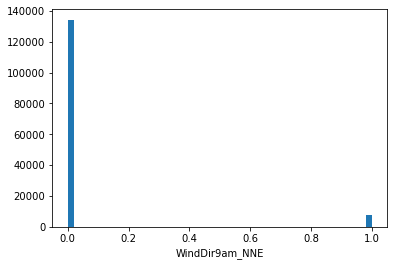

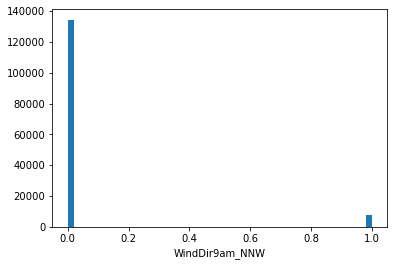

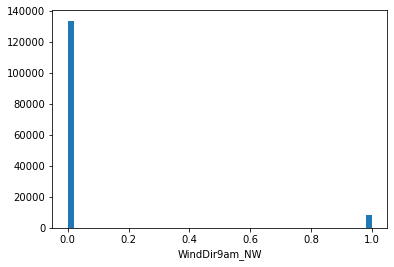

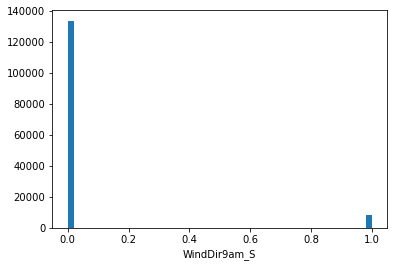

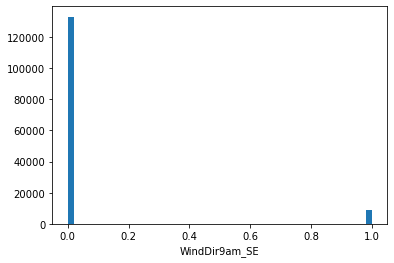

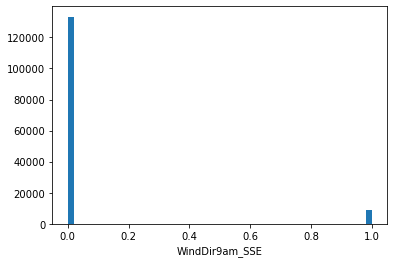

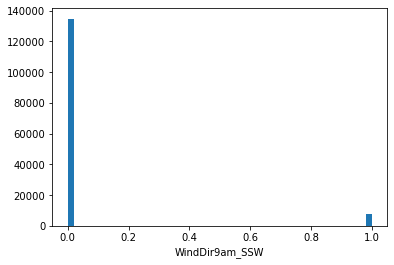

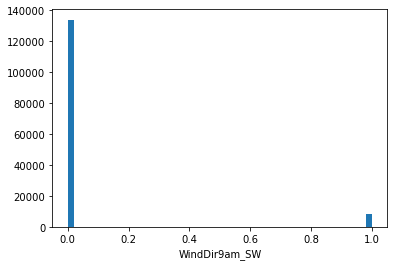

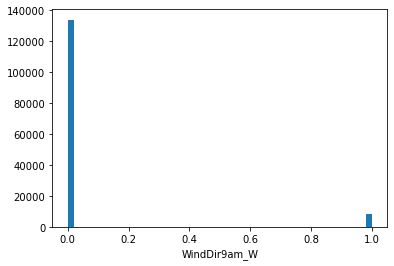

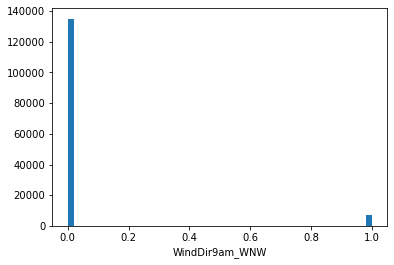

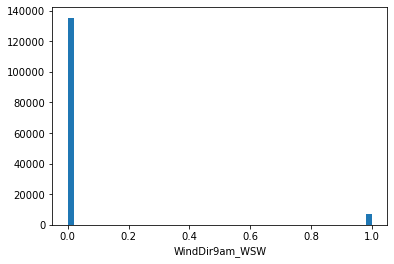

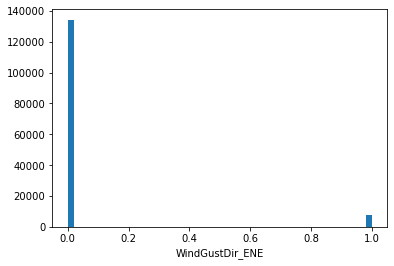

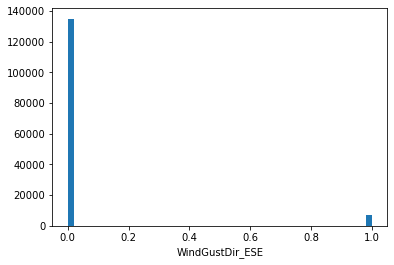

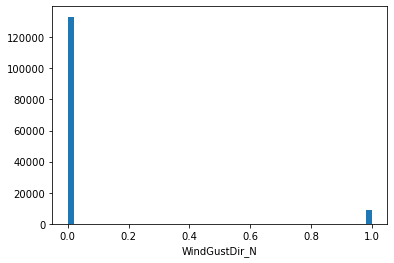

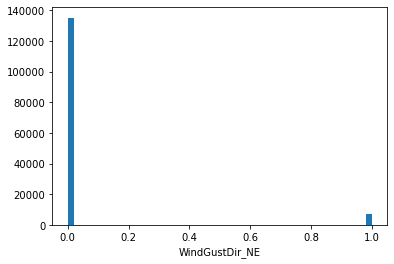

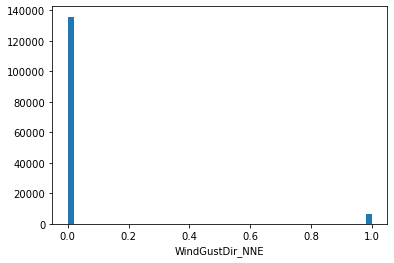

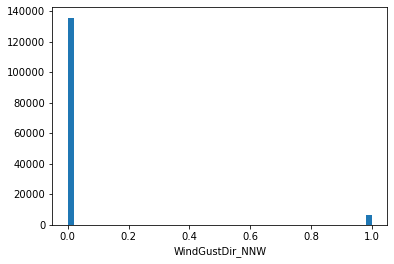

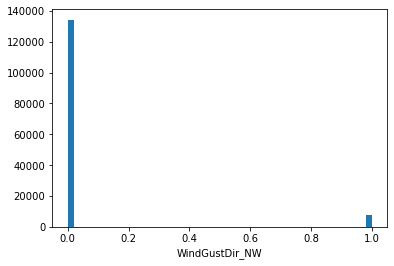

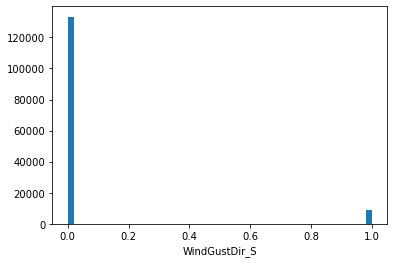

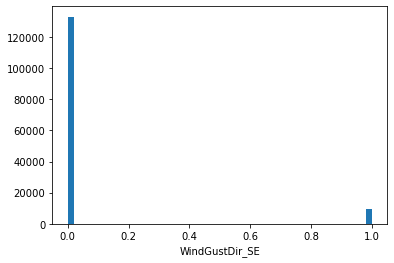

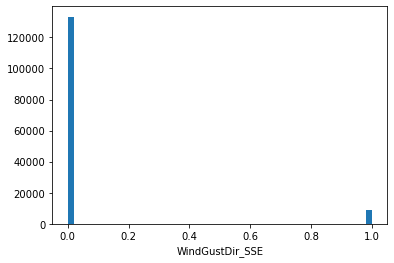

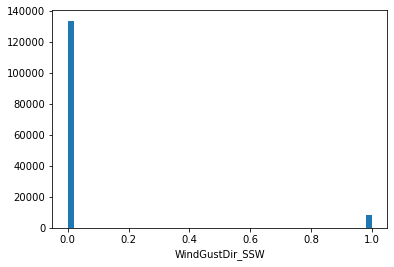

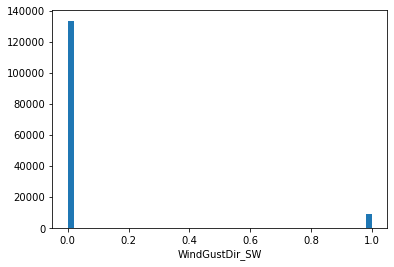

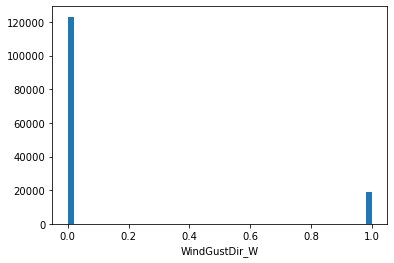

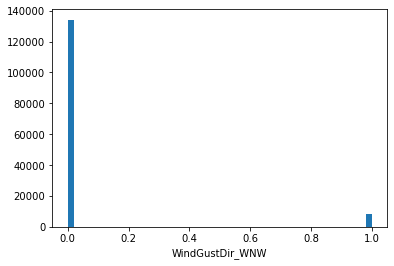

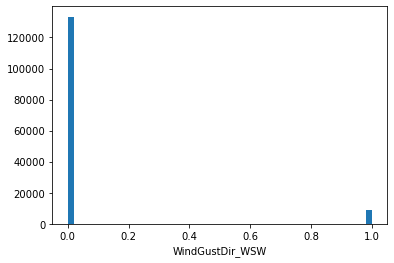

In [37]:
for col in data.columns:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

## Проведение корреляционного анализа данных

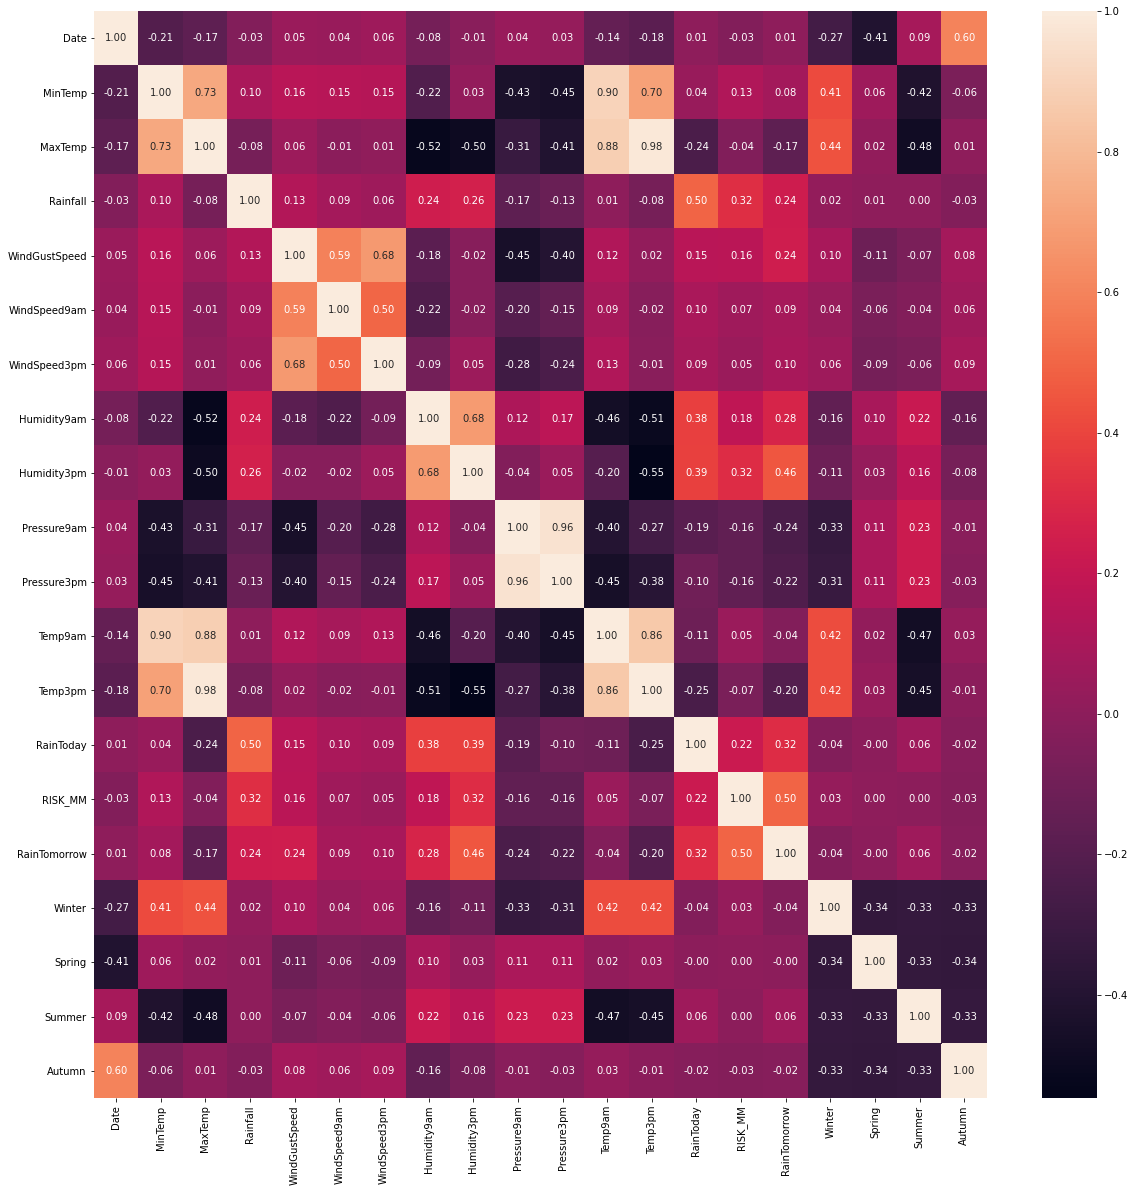

In [39]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.show()

На основе корреляционной матрицы можно сделать следующие выводы:

- Целевой признак классификации RainTomorrow наиболее сильно коррелирует с Rainfall, WindGustSpeed, Humidity9am, Humidity3pm, RainToday, RISK_MM
- RISK_MM коррелирует с теми же признаками и фактически я вляется преобразованием RainTomorrow, так что лучше не использовать его в модели

## Выбор метрик для последующей оценки качества моделей

- Метрики, формируемые на основе матрицы ошибок:


    - precision

$$precision=\frac{TP}{TP+FP}$$
Доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные.
    - recall
    
$$recall=\frac{TP}{TP+FN}$$
Доля верно предсказанных классификатором положительных объектов, из всех действительно положительных объектов.
    - f1 score
    
$$F_1=2⋅\frac{precision⋅recall}{precision+recall}$$
Среднее гармоническое от precision и recall

- Метрика ROC AUC
Для построения ROC-кривой:

$$TPR=\frac{TP}{TP+FN}$$ 
True Positive Rate, откладывается по оси ординат. Совпадает с recall.

$$FPR=\frac{FP}{FP+TN}$$ 
False Positive Rate, откладывается по оси абсцисс. Показывает какую долю из объектов отрицательного класса алгоритм предсказал неверно.

В качестве количественной метрики используется площадь под кривой - ROC AUC (Area Under the Receiver Operating Characteristic Curve). Чем ниже проходит кривая тем меньше ее площадь и тем хуже качество классификатора.

In [19]:
metrics = MetricLogger()

## Разделение выборки на обучающую и тестовую

In [17]:
y = data['RainTomorrow']
X = data[['Rainfall', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm', 'RainToday']]

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

## Выбор наиболее подходящих моделей для решения задачи классификации или регрессии

Для задачи классификации будем использовать следующие модели:

- Логистическая регрессия
- Метод ближайших соседей
- Машина опорных векторов
- Решающее дерево
- Случайный лес
- Сверхслучайные деревья
- Градиентный бустинг

## Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров

In [43]:
models = {'LogR': LogisticRegression(), 
               'KNN_5':KNeighborsClassifier(n_neighbors=5),
               'Tree':DecisionTreeClassifier(),
               'SVC':SVC(probability=True),
               'RF':RandomForestClassifier(),
               'ET':ExtraTreesClassifier(),
               'GB':GradientBoostingClassifier()}

In [60]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, ax, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    #plt.figure()
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_xlim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")

In [58]:
def clas_train_model(model_name, model, X_train, y_train, X_test, y_test, clasMetricLogger):
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    Y_pred_proba_temp = model.predict_proba(X_test)
    Y_pred_proba = Y_pred_proba_temp[:,1]
    
    precision = precision_score(y_test.values, Y_pred)
    recall = recall_score(y_test.values, Y_pred)
    f1 = f1_score(y_test.values, Y_pred)
    roc_auc = roc_auc_score(y_test.values, Y_pred_proba)
    
    clasMetricLogger.add('precision', model_name, precision)
    clasMetricLogger.add('recall', model_name, recall)
    clasMetricLogger.add('f1', model_name, f1)
    clasMetricLogger.add('roc_auc', model_name, roc_auc)

    fig, ax = plt.subplots(ncols=2, figsize=(10,5))    
    draw_roc_curve(y_test.values, Y_pred_proba, ax[0])
    plot_confusion_matrix(model, X_test, y_test.values, ax=ax[1],
                      display_labels=['0','1'], 
                      cmap=plt.cm.Blues, normalize='true')
    fig.suptitle(model_name)
    plt.show()

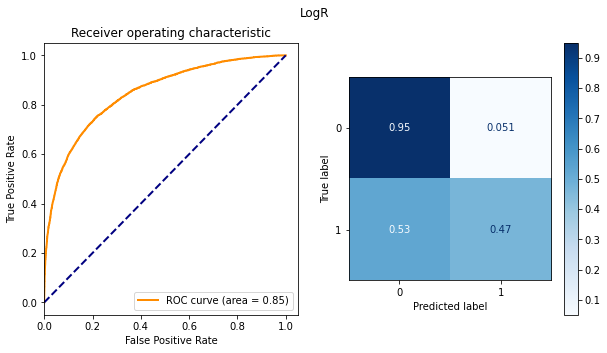

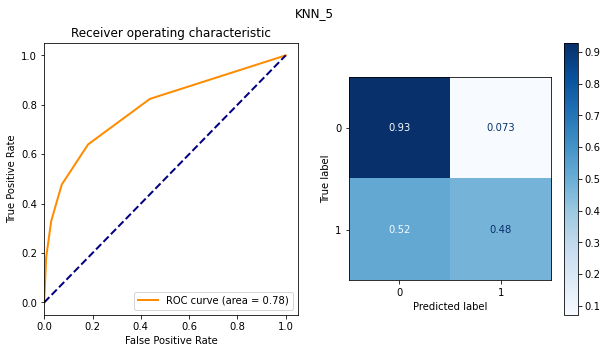

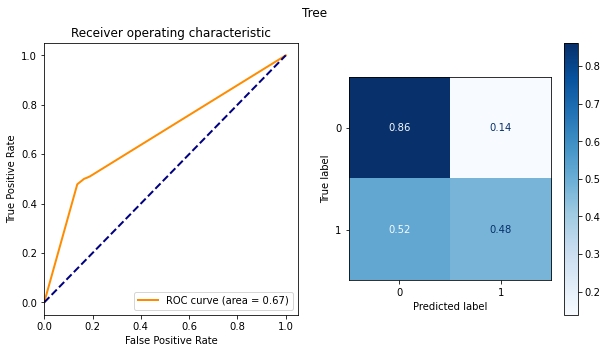

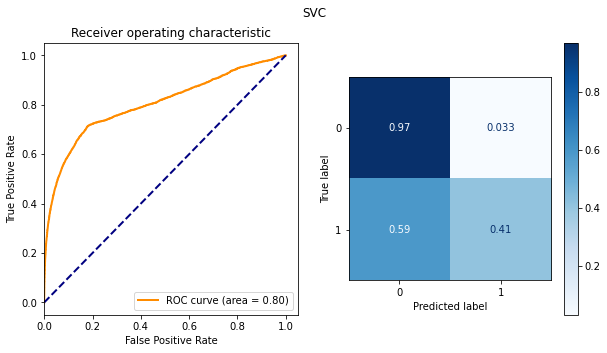

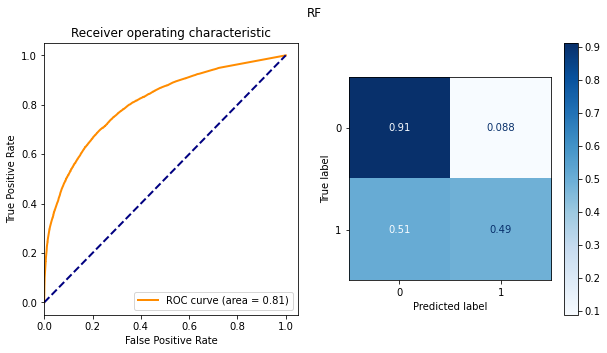

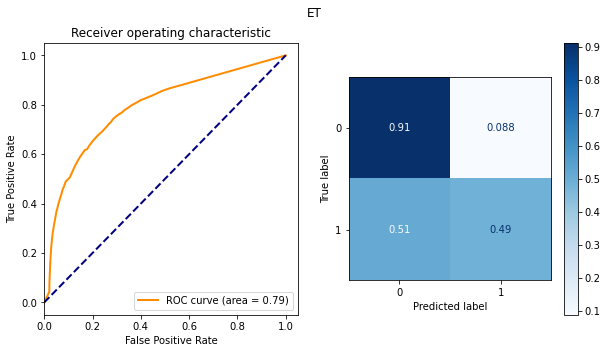

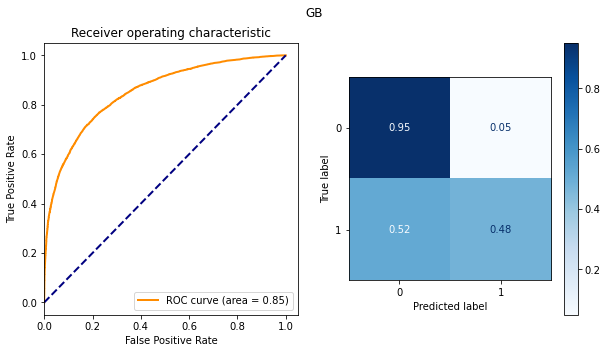

In [47]:
for model_name, model in models.items():
    clas_train_model(model_name, model, X_train, y_train, X_test, y_test, metrics)

## Подбор гиперпараметров для выбранных моделей

Logistic Regression

In [20]:
param_log = [{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

In [105]:
%%time
lr_gs = GridSearchCV(LogisticRegression(), param_log, cv=5, scoring='r2')
lr_gs.fit(data.head(20000), y.head(20000))

CPU times: user 12.7 s, sys: 150 ms, total: 12.8 s
Wall time: 1.62 s


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}])

In [106]:
lr_gs.best_params_, lr_gs.best_score_

({'C': 0.01}, 1.0)

KNN

In [62]:
param_knn = [{'n_neighbors': np.array(range(1,25,1))}]

In [63]:
%%time
knn_gs = GridSearchCV(KNeighborsClassifier(), param_knn, cv=5)
knn_gs.fit(data, y)

CPU times: user 17min 18s, sys: 1.2 s, total: 17min 19s
Wall time: 17min 19s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])}])

In [64]:
knn_gs.best_params_, knn_gs.best_score_

({'n_neighbors': 1}, 1.0)

In [38]:
%%time
knn_gs = GridSearchCV(KNeighborsClassifier(), param_knn, cv=StratifiedKFold(n_splits=5), scoring='r2')
knn_gs.fit(data.head(2000), y.head(2000))

CPU times: user 2.3 s, sys: 6.08 ms, total: 2.31 s
Wall time: 2.31 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])}],
             scoring='r2')

In [39]:
knn_gs.best_params_, knn_gs.best_score_

({'n_neighbors': 1}, 1.0)

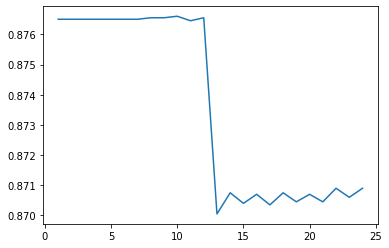

In [47]:
plt.plot(np.array(range(1,25,1)), knn_gs.cv_results_['mean_test_score'])

DecisionTreeClassifier

In [31]:
param_dt = [{"max_depth": [5, 10, None],
            "max_features": range(1, 5),
            'min_samples_split': [2, 5, 10, 20],
            "min_samples_leaf": range(1, 5)}]

In [41]:
%%time
dt_gs = GridSearchCV(DecisionTreeClassifier(), param_dt, cv=StratifiedKFold(n_splits=5), scoring='r2')
dt_gs.fit(data.head(20000), y.head(20000))

CPU times: user 7.73 s, sys: 18.4 ms, total: 7.75 s
Wall time: 7.75 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [5, 10, None],
                          'max_features': range(1, 5),
                          'min_samples_leaf': range(1, 5),
                          'min_samples_split': [2, 5, 10, 20]}],
             scoring='r2')

In [42]:
dt_gs.best_params_, dt_gs.best_score_

({'max_depth': 5,
  'max_features': 4,
  'min_samples_leaf': 1,
  'min_samples_split': 2},
 1.0)

SVC

In [43]:
param_svc = [
  {'C': [1, 10, 100], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

In [44]:
%%time
svc_gs = GridSearchCV(SVC(probability=True), param_svc, cv=StratifiedKFold(n_splits=5), scoring='r2')
svc_gs.fit(data.head(20000), y.head(20000))

CPU times: user 3min 48s, sys: 5.4 s, total: 3min 54s
Wall time: 3min 54s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(probability=True),
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             scoring='r2')

In [45]:
svc_gs.best_params_, svc_gs.best_score_

({'C': 1, 'kernel': 'linear'}, 1.0)

RandomForestClassifier

In [47]:
param_rf = [{'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5, 10],
            "min_samples_leaf": range(1, 9),
            "max_features": range(1, 5)}]

In [48]:
%%time
rf_gs = GridSearchCV(RandomForestClassifier(), param_rf, cv=StratifiedKFold(n_splits=5), scoring='r2')
rf_gs.fit(data.head(20000), y.head(20000))

CPU times: user 11min 36s, sys: 3.54 s, total: 11min 40s
Wall time: 11min 40s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [3, 5, 10, None],
                          'max_features': range(1, 5),
                          'min_samples_leaf': range(1, 9),
                          'min_samples_split': [2, 5, 10]}],
             scoring='r2')

In [49]:
rf_gs.best_params_, rf_gs.best_score_

({'max_depth': 3,
  'max_features': 4,
  'min_samples_leaf': 2,
  'min_samples_split': 2},
 1.0)

ExtraTreesClassifier

In [50]:
param_et = [{'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5, 10],
            "min_samples_leaf": range(1, 9),
            "max_features": range(1, 5),
            "criterion": ["gini", "entropy"]}]

In [51]:
%%time
et_gs = GridSearchCV(ExtraTreesClassifier(), param_et, cv=StratifiedKFold(n_splits=5), scoring='r2')
et_gs.fit(data.head(20000), y.head(20000))

CPU times: user 14min 51s, sys: 5.91 s, total: 14min 56s
Wall time: 14min 57s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=ExtraTreesClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [3, 5, 10, None],
                          'max_features': range(1, 5),
                          'min_samples_leaf': range(1, 9),
                          'min_samples_split': [2, 5, 10]}],
             scoring='r2')

In [52]:
et_gs.best_params_, et_gs.best_score_

({'criterion': 'gini',
  'max_depth': 3,
  'max_features': 4,
  'min_samples_leaf': 1,
  'min_samples_split': 2},
 1.0)

GradientBoostingClassifier

In [53]:
param_gb = [{'learning_rate':[0.01,0.1,1,10,100], 
             'n_estimators':[50,100,250],
             'max_depth':[2,3,4,5]}]

In [54]:
%%time
gb_gs = GridSearchCV(GradientBoostingClassifier(), param_gb, cv=StratifiedKFold(n_splits=5), scoring='r2')
gb_gs.fit(data.head(2000), y.head(2000))

CPU times: user 58.6 s, sys: 54.2 ms, total: 58.7 s
Wall time: 58.7 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(),
             param_grid=[{'learning_rate': [0.01, 0.1, 1, 10, 100],
                          'max_depth': [2, 3, 4, 5],
                          'n_estimators': [50, 100, 250]}],
             scoring='r2')

In [ ]:
%%time
gb_gs = GridSearchCV(GradientBoostingClassifier(), param_gb, cv=StratifiedKFold(n_splits=5), scoring='r2')
gb_gs.fit(data.head(20000), y.head(20000))

In [55]:
gb_gs.best_params_, gb_gs.best_score_

({'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50}, 1.0)

## Сравнение качества полученных моделей с качеством baseline-моделей

In [56]:
models_grid = {'LogR': LogisticRegression(), 
               'LogR_grid': lr_gs.best_estimator_, 
               'KNN_5':KNeighborsClassifier(n_neighbors=5),
               'KNN_grid': knn_gs.best_estimator_,
               'Tree':DecisionTreeClassifier(),
               'Tree_grid': dt_gs.best_estimator_,
               'SVC':SVC(probability=True),
               'SVC_grid': svc_gs.best_estimator_,
               'RF':RandomForestClassifier(),
               'RF_grid': rf_gs.best_estimator_,
               'ET':ExtraTreesClassifier(),
               'ET_grid': et_gs.best_estimator_,
               'GB':GradientBoostingClassifier(),
               'GB_grid': gb_gs.best_estimator_
              }

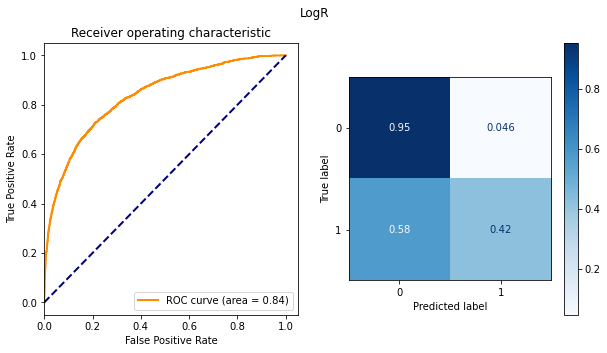

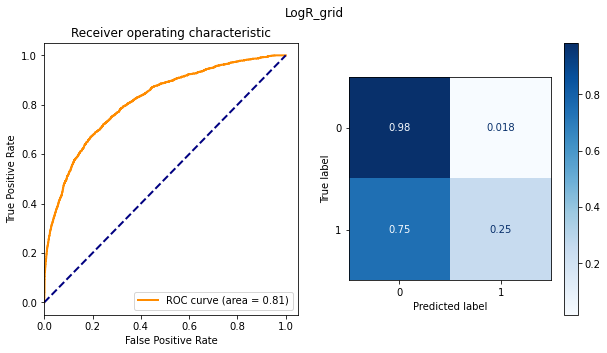

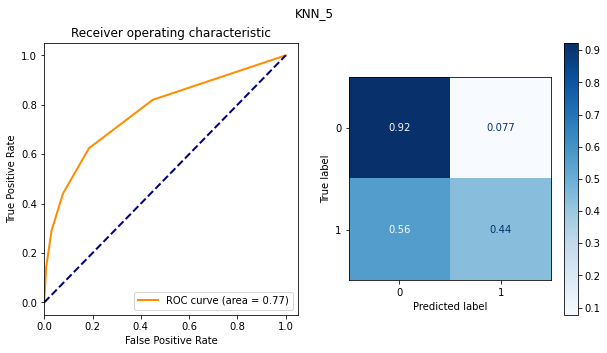

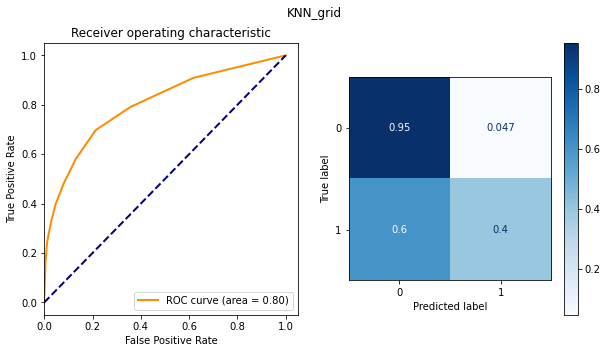

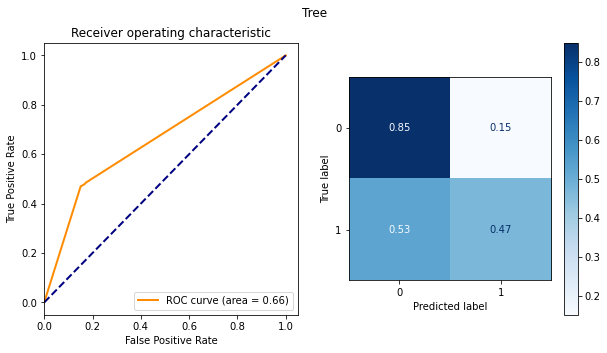

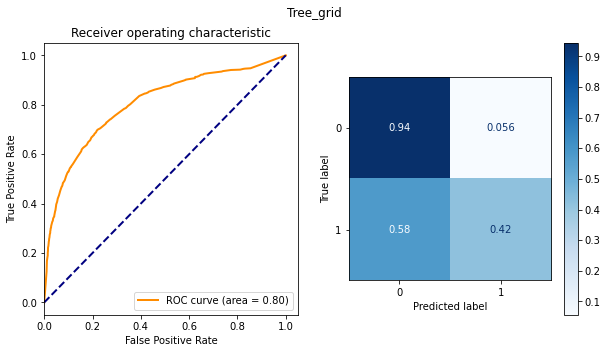

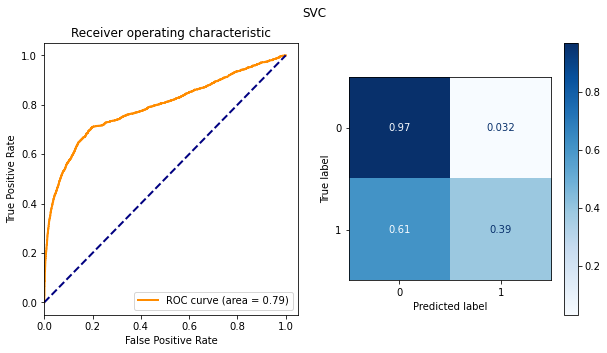

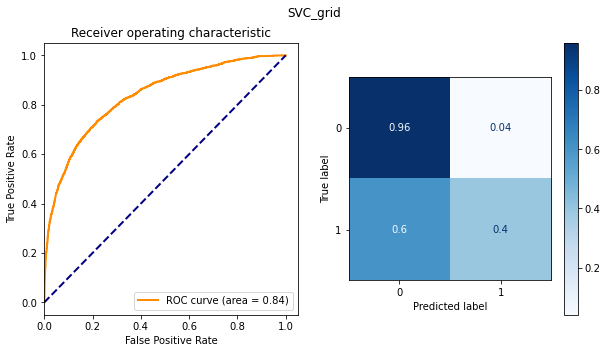

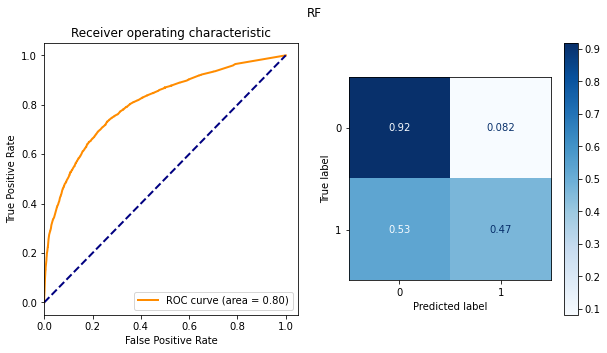

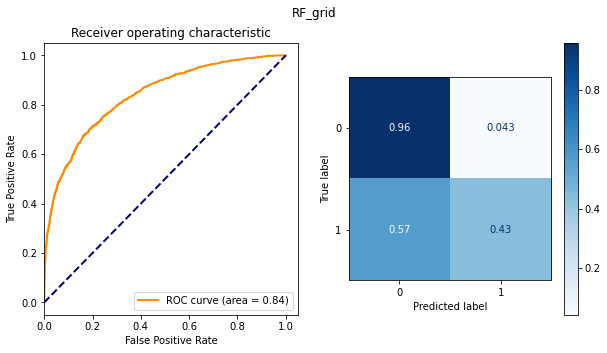

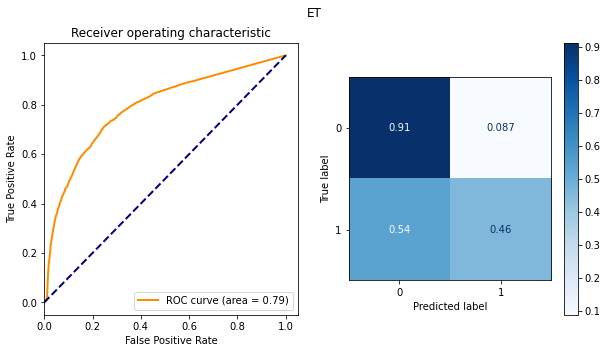

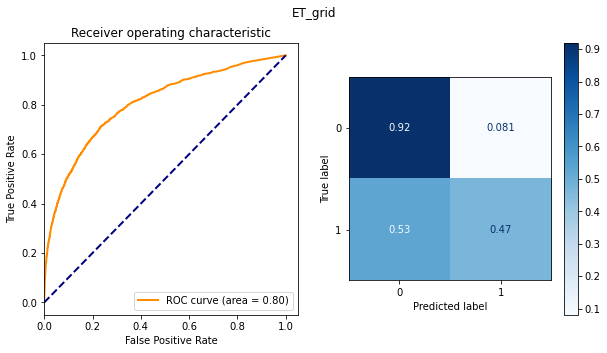

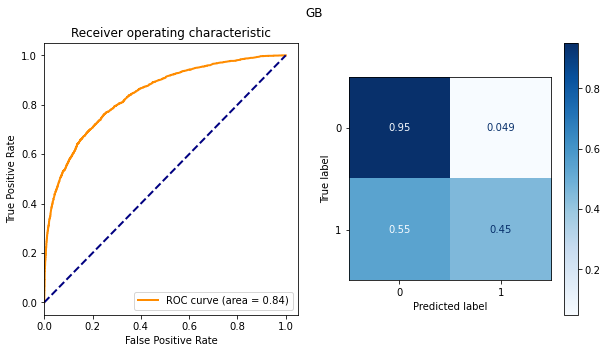

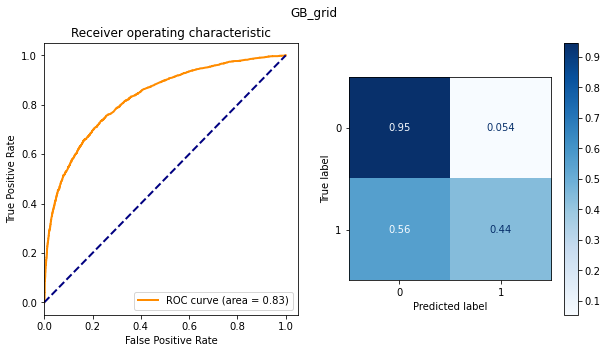

In [126]:
for model_name, model in models_grid.items():
    clas_train_model(model_name, model, X_train.head(20000), y_train.head(20000), X_test.head(10000), y_test.head(10000), metrics)

## Формирование выводов о качестве построенных моделей на основе выбранных метрик

In [127]:
clas_metrics = metrics.df['metric'].unique()

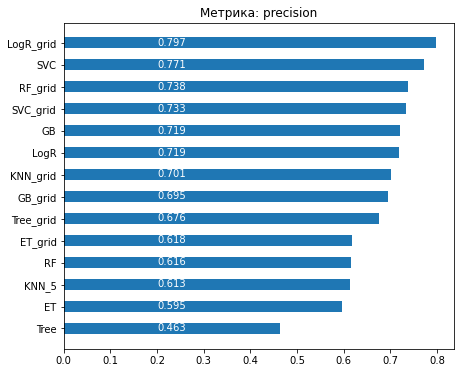

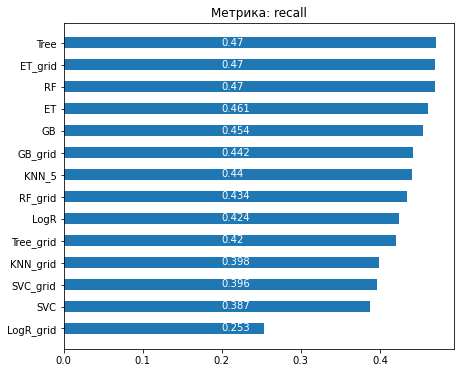

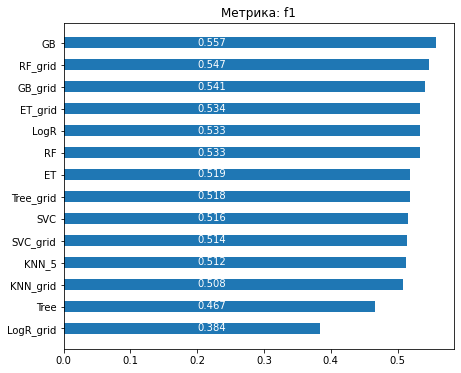

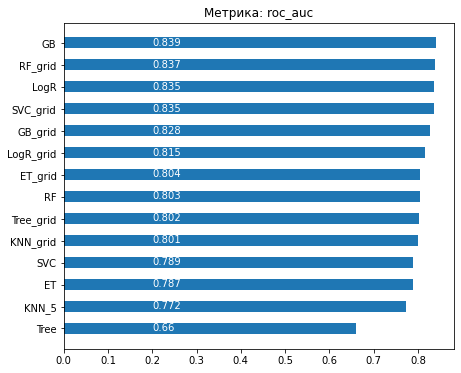

In [128]:
for metric in clas_metrics:
    metrics.plot('Метрика: ' + metric, metric, figsize=(7, 6))

На основании двух метрик из четырех используемых, лучшей оказалась модель градиентного бустинга